In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner_v3")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict

from utils.quadratic import Quadratic, Quadratic2D, SimpleQuadratic
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from models.layer_norm_lstm import LayerNormLSTMCell
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_val_result, plot_exper_losses, plot_parm_loss_steps
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [(True, "run_20170601_17_36_15_metaV1_10ep_20ops_lr1e05_adam"),
                  (False, "run_20170521_14_31_50_metaV1_30ep_5ops_lr5e05_adam"),
                  (False, "run_20170521_14_28_52_metaV1_30ep_2ops_lr5e05_adam"),
                  # META V2 model (trained with T samples)
                  (False, "run_20170521_16_29_59_metaV2_30ep_10ops_lr5e05_adam"),
                  (False, "run_20170521_16_44_03_metaV2_30ep_5ops_lr5e05_adam"),
                  (False, "run_20170521_16_40_41_metaV2_30ep_2ops_lr5e05_adam"),
                  # ACT V1 model (2 LSTMS)
                  (False, "run_20170521_15_04_08_actV2.1_30ep_10ops_lr5e05_adam"),
                  (False, "run_20170521_14_52_18_actV2.1_30ep_5ops_lr5e05_adam"),
                  (False, "run_20170521_14_58_37_actV2.1_30ep_2ops_lr5e05_adam"),
                  # ACT V2 model (1 LSTM)
                  (True, 'run_20170601_17_57_07_actV2_20ep_20ops_lr1e05_adam'),
                  (False, "run_20170521_13_16_49_actV2_30ep_10ops_lr5e05_adam"),
                  (False, "run_20170521_13_25_12_actV2_30ep_5ops_lr5e05_adam"),
                  (False, "run_20170521_13_12_00_actV2_30ep_2ops_lr5e05_adam")]



In [5]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        print("{} Loading model {}".format(m, exp.args.model))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


INFO - INFO - loaded existing model from file logs/run_20170601_17_36_15_metaV1_10ep_20ops_lr1e05_adam/metaV1_lr1e-05_adam_20ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170601_17_36_15_metaV1_10ep_20ops_lr1e05_adam/metaV1_lr1e-05_adam_20ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170601_17_36_15_metaV1_10ep_20ops_lr1e05_adam/metaV1_lr1e-05_adam_20ops.pkl


0 Loading model metaV1_lr1e-05_adam_20ops
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'linear_out.bias']


INFO - INFO - loaded existing model from file logs/run_20170601_17_57_07_actV2_20ep_20ops_lr1e05_adam/actV2_lr1e-05_adam_20ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170601_17_57_07_actV2_20ep_20ops_lr1e05_adam/actV2_lr1e-05_adam_20ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170601_17_57_07_actV2_20ep_20ops_lr1e05_adam/actV2_lr1e-05_adam_20ops.pkl


1 Loading model actV2_lr1e-05_adam_20ops
['lambda_q', 'linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'linear_out.bias', 'act_linear_out.weight', 'act_linear_out.bias']


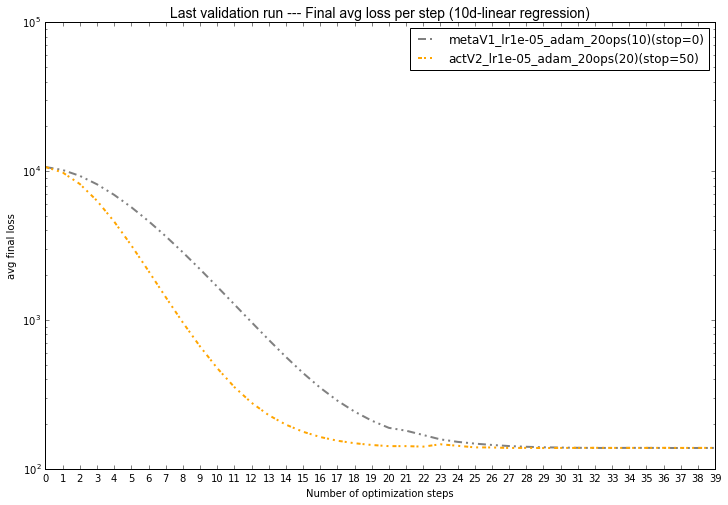

In [8]:
# new_exp_only = [experiments[0], experiments[2], experiments[4]]
best_val_runs, lowest_value = plot_val_result(experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="compare_metaV1_actV2", 
                                              loss_type="loss",
                                              max_step=40,
                                              sort_exper="10d-linear regression",
                                              log_scale=True)

3
model: metaV1_lr5e-05_adam_10ops best val run 5 = 0.0010 / step 8
model: metaV1_lr5e-05_adam_5ops best val run 5 = 0.0010 / step 6
model: metaV1_lr5e-05_adam_2ops best val run 10 = 0.0010 / step 22


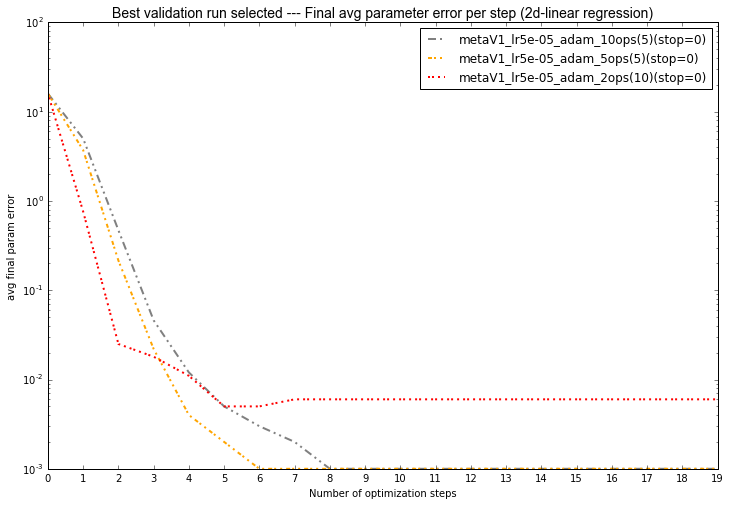

In [50]:
print(len(experiments))
best_val_runs, lowest_value = plot_val_result(experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=True,
                                              fig_name="lreg3_val_10000_compare_models", 
                                              loss_type="param_error",
                                              max_step=20,
                                              sort_exper="2d-linear regression",
                                              log_scale=True)

INFO - Successfully saved fig figures/exp3_compare_actV2_param_error_validation_09_17_32.png


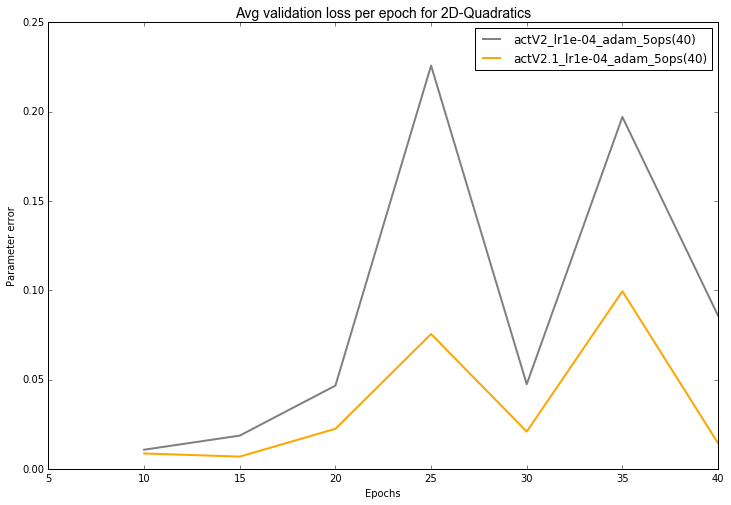

In [44]:
# exp_error_curves = [experiments[0],  experiments[3]]
plot_exper_losses(experiments, loss_type="param_error", offset=2, N=1, 
                  do_save=True, 
                  fig_name="exp3_compare_actV2_param_error_validation",
                  validation=True)


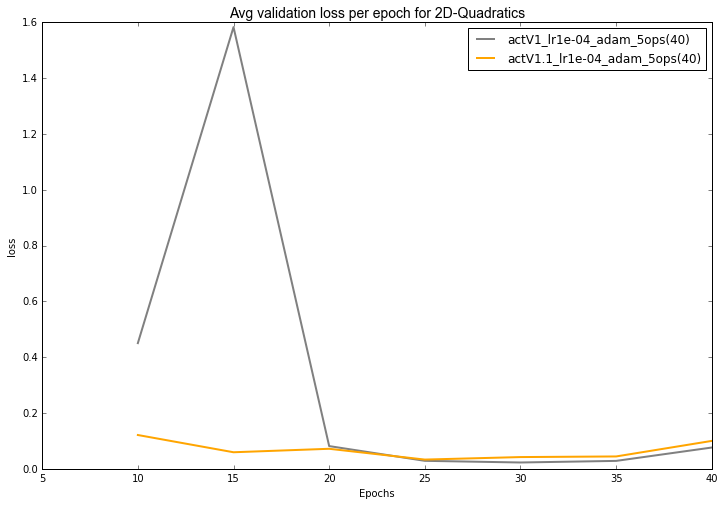

In [57]:
plot_exper_losses(exp_error_curves, loss_type="loss", offset=2, N=3, do_save=False, 
                  fig_name="param_error_curves", validation=True)


INFO - Successfully saved fig figures/expv5_val_results_1000_loss_10ops_12_01_09.png


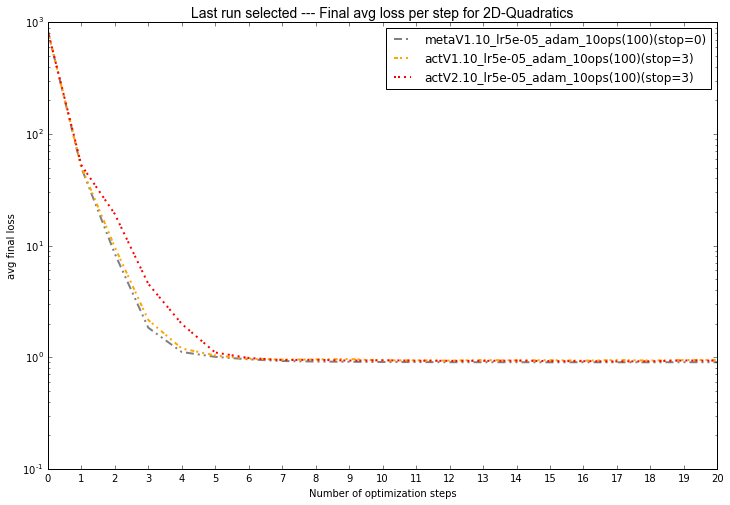

In [27]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [16]:
print(new_experiments[1].val_avg_num_opt_steps)

3


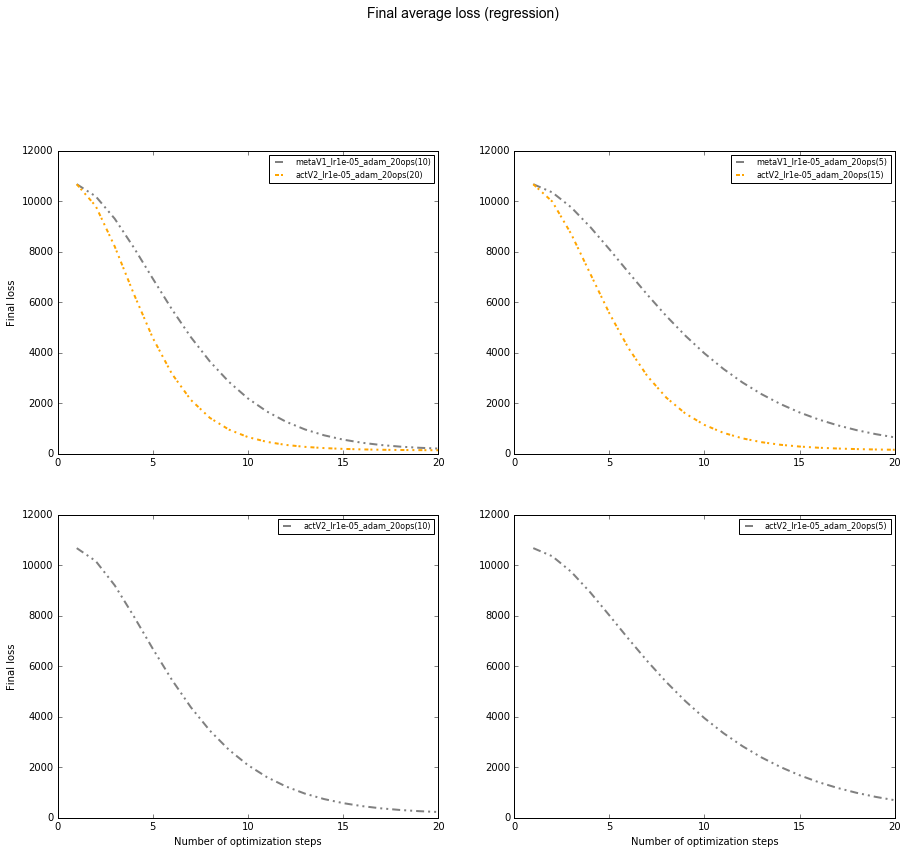

In [12]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [4]:
with open("data/val_funcs_10000_100_1.0_2d_linear.dll", 'rb') as f:
    val_funcs = dill.load(f)


In [12]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 10000
r_funcs = RegressionFunction(n_funcs=num_of_val_funcs, n_samples=100, noise_sigma=1., poly_degree=2, 
                             non_linear=False)


In [21]:
with open("data/val_funcs_1000.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [5]:
print(config.max_val_opt_steps)

20


INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 200: Validating model actV2_lr5e-05_adam_20ops with 10000 functions


1
Validating model actV2_lr5e-05_adam_20ops


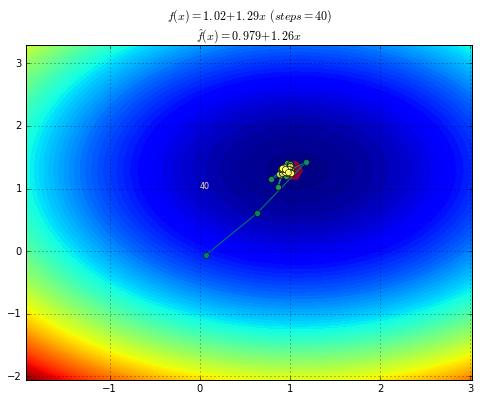

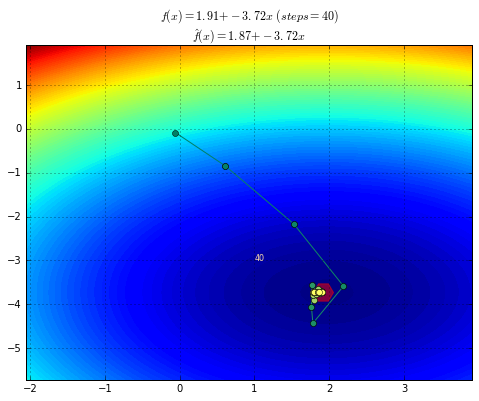

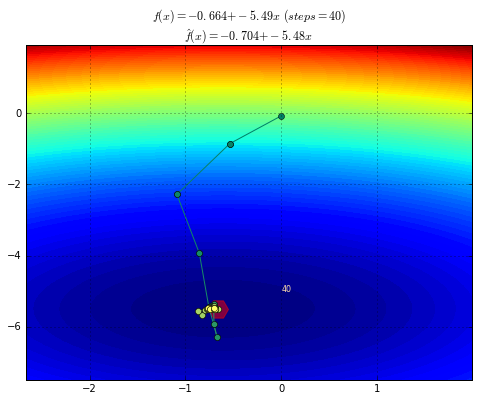

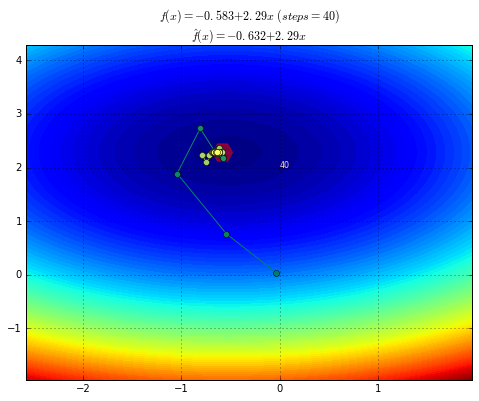

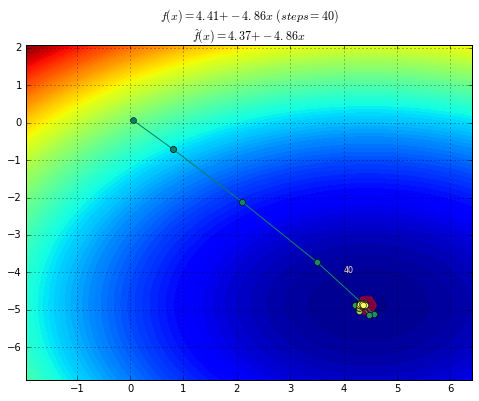

INFO - INFO - Average stopping-step: 26
INFO - INFO - Epoch 200: Final validation average ACT-loss: 146.9
INFO - INFO - Epoch 200: Final validation average loss / param-loss: 145.3/0.001519
INFO - INFO - Epoch 200: Final step param-losses: [  1.5931e+01   1.1678e+01   6.2700e+00   2.6300e+00   9.3100e-01
   3.0000e-01   9.2000e-02   2.7000e-02   9.0000e-03   4.0000e-03
   3.0000e-03   3.0000e-03   3.0000e-03   2.0000e-03   2.0000e-03
   2.0000e-03   2.0000e-03   2.0000e-03   2.0000e-03   1.0000e-03
   1.0000e-03   3.0000e-03   2.0000e-02   1.8000e-02   7.0000e-03
   1.0000e-03   0.0000e+00   2.0000e-03   5.0000e-03   6.0000e-03
   4.0000e-03   1.0000e-03   1.0000e-03   1.0000e-03   3.0000e-03
   6.0000e-03   6.0000e-03   3.0000e-03   1.0000e-03   1.0000e-03
   2.0000e-03]
INFO - INFO - Epoch 200: Final step losses: [ 2027.512  1524.356   884.182   454.075   253.935   180.108   155.777
   148.214   146.105   145.505   145.348   145.314   145.302   145.297
   145.293   145.268   145.25  

In [7]:
print(len(new_experiments))
exp_idx = 0
new_experiments[exp_idx].epoch = 200
new_experiments[exp_idx].config.max_val_opt_steps = 40
# the same object for the validation data
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
model = models[exp_idx]
print("Validating model {}".format(model.name))

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=val_funcs, 
                   max_steps=40, verbose=False, plot_func=True, show_plot=True, save_plot=False,
                   num_of_plots=5)

In [156]:
# exper = get_experiment('run_20170515_13_53_49_actV2_20ep_10ops_lr5e05_adam')
exper = get_experiment("run_20170525_19_39_19_actV2_30ep_20ops_lr5e05_adam")

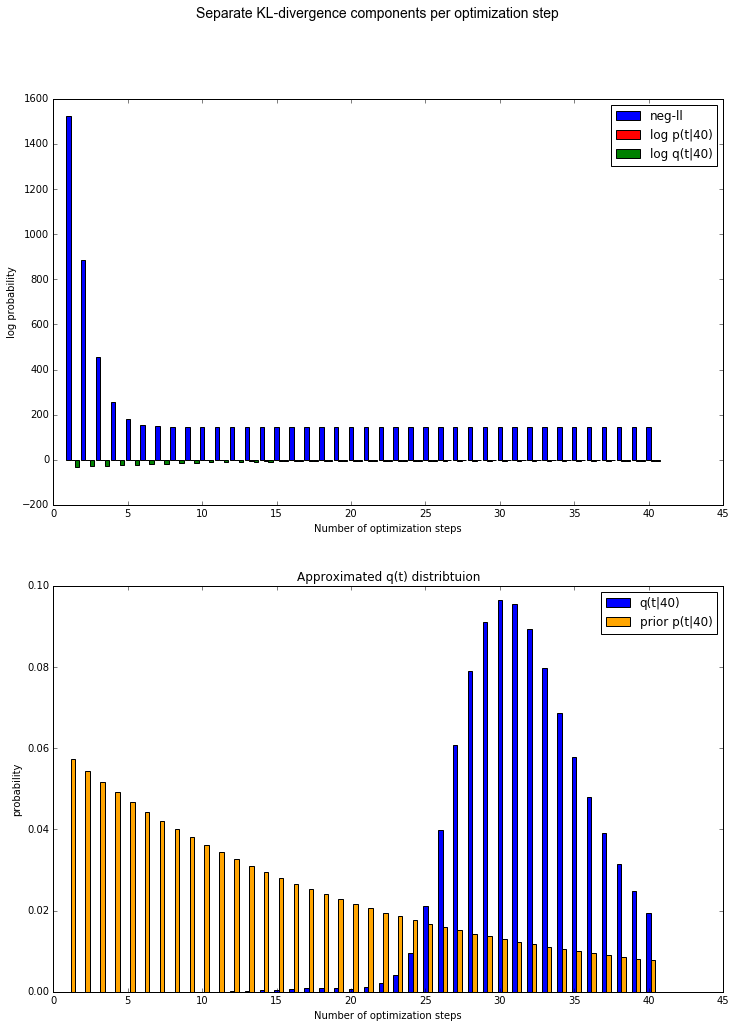

In [157]:
# 
plot_kl_div_parts(exper, save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

INFO - Successfully saved fig logs/run_20170525_19_39_19_actV2_30ep_20ops_lr5e05_adam/qt_T_dist_val_actV2_30ep_20ops.png


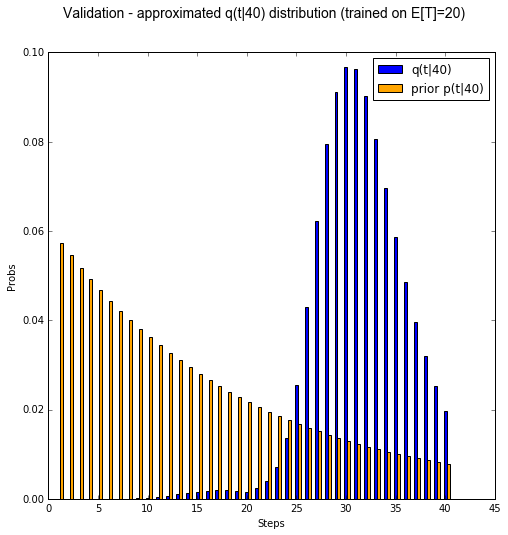

In [161]:
plot_qt_probs(exper, data_set="val", save=True, show=True, 
              plot_prior=True, height=8, width=8, plot_idx=[40])

In [64]:
T = 18
qt = exper.val_stats["qt_hist"][30][T]
print(qt)

[  1.16585789e-07   2.66455341e-07   8.52595804e-07   3.67424379e-06
   1.81194540e-05   8.79444469e-05   3.64762319e-04   1.24599301e-03
   3.59000583e-03   8.96660400e-03   1.96767564e-02   3.81288907e-02
   6.54934732e-02   1.00561880e-01   1.39735819e-01   1.77958442e-01
   2.10353361e-01   2.33813039e-01]


In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

[ 0.19309185  0.25614058  0.24058133  0.1808318   0.12935445]
[ 93.69465637  92.56275177  92.43516541  92.43141174  92.43121338
  92.42720032]
[ 0.11887669  0.23429963  0.27020574  0.21978717  0.15683077]
[ 104.62787628   92.92465973   92.43505859   92.42867279   92.42709351
   92.42713928]
[ 0.00903103  0.06211803  0.27155532  0.37283278  0.28446285]
[ 148.68551636  108.54633331   92.52172089   92.56498718   92.44163513
   92.43159485]
[ 0.02397113  0.11330524  0.29825712  0.32578054  0.23868597]
[ 130.93403625  101.6027832    92.51012421   92.4836731    92.43185425
   92.42990875]
[ 0.10979466  0.24725738  0.27810491  0.21425693  0.15058612]
[ 99.56502533  92.709198    92.44354248  92.42796326  92.42944336
  92.42945862]
[ 0.0390434   0.16535978  0.31182257  0.28158466  0.20218959]
[ 118.25817871   95.21542358   92.51622772   92.43270111   92.42834473
   92.43013   ]


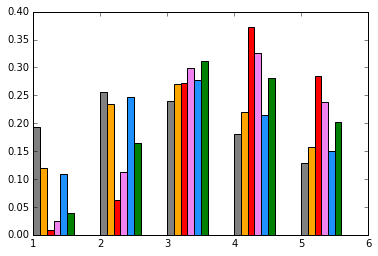

In [155]:
func_idx = [1, 15, 2499, 4999, 7499, 9999]
bar_width = 0.1
p_colors = ['grey', 'orange', 'red', 'violet', 'dodgerblue', 'green', 'darkviolet']
    
for i, idx in enumerate(func_idx):
    qt = exper.val_stats["qt_funcs"][5][idx]
    loss = exper.val_stats["loss_funcs"][idx,0:5+1]
    print(qt)
    print(loss)
    index = np.arange(1, len(qt)+1)
    plt.bar(index+ (i*bar_width), qt, bar_width, color=p_colors[i], label="f_{}".format(idx))

In [148]:
len(exper.val_stats["loss_funcs"][0])

10000